In [79]:
import numpy as np
import os 
import re
import random
import pandas as pd
import subprocess
import shutil
import time


from pymatgen.core import Structure
from pymatgen.core import Element
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen.core import Composition

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage

##---------PREPARE INPUTS VC-RELAX FROM CIF--------##

AtomSymb = np.asarray([str(e) for e in Element])[2:]
AtomMass = np.asarray([str(float(Element(e).atomic_mass)) for e in AtomSymb]) 

qe_input = {"calculation_type" : "vc-relax", 
"pseudo_dir" : "./pseudo",
"pseudo_tail" : "_ONCV_PBE_sr.upf",
"ecutwfc" : 80,
"occupations_scf" : "smearing",
"smearing_scf" : "marzari-vanderbilt",
"degauss_scf" : 0.02,
"el_conv_thr" : 1.0e-7,
"mixing_beta" : 0.7,
"ion_dynamics" : "bfgs",
"cell_dofree" : "ibrav",
"cell_dynamics" : "bfgs",
"press" : 500.0,
"kspacing_scf" : 0.25,
"kspacing_nscf" : 0.10,
"forc_conv_thr" : 1e-3,
"etot_conv_thr" : 1e-5,
"cell_factor" : 4.0 }


bohr_to_angstrom = 0.52917720859 # Bohr radius
grk_pi = 3.14159265358979323846  # pi
rad_to_deg = 180 / grk_pi        # from radians to degrees

#a, b, c are input qe parameters
def make_kmesh(a, b, c, spacing = 0.30):
    KP_x = int(2.*grk_pi / (a * spacing) + 0.5)
    if KP_x < 1:
        KP_x = 1
    KP_y = int(2.*grk_pi / (b * spacing) + 0.5)
    if KP_y < 1:
        KP_y = 1
    KP_z = int(2.*grk_pi / (c * spacing) + 0.5)
    if KP_z < 1:
        KP_z = 1
    return [KP_x, KP_y, KP_z]  ## number of kpoints in each direction

# Given ibrav value and angle in rad returns the lattice vectors of primitive and conventional cell
def get_bravais_vectors(ibrav, alphar, betar, gammar):
    if ibrav == 1:
        ## 1: simple_cubic
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        return conventional, primitive
    elif ibrav == 2:
        ## 2: face_centered_cubic
        conventional =  np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[-1/2,0,1/2],
                                 [0,1/2,1/2],
                                 [-1/2,1/2,0]])
    elif ibrav == 3:
        ## 3: body_centered_cubic
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,1/2,1/2],
                                 [-1/2,1/2,1/2],
                                 [-1/2,-1/2,1/2]])
    elif ibrav == 4:
        ## 4: simple_hexagonal
        conventional = np.asarray([[1,0,0],
                                 [-1/2,np.sqrt(3)/2,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [-1/2,np.sqrt(3)/2,0],
                                 [0,0,1]])
    elif ibrav == 5:
        raise Warning("Trigonal axes not yet implemented.")
    elif ibrav == -5:
        raise Warning("Trigonal axes not yet implemented.")
    
    elif ibrav == 6:
    ## 6: simple_tetragonal
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
    elif ibrav == 7:
        ## 7: body_centered_tetragonal
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive =  np.asarray([[1/2,-1/2,1/2],
                                 [1/2,1/2,1/2],
                                 [-1/2,-1/2,1/2]])
    elif ibrav == 8:
        ## 8: orthorhombic_simple
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
    elif ibrav == 9:
        ## 9: orthorhombic_base_centered
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,1/2,0],
                                 [-1/2,1/2,0],
                                 [0,0,1]])
    elif ibrav == -9:
        ## -9: orthorhombic_base_centered
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,-1/2,0],
                                 [1/2,1/2,0],
                                 [0,0,1]])
    elif ibrav == 91:
     ## 91: orthorhombic_one_base_centered_a_type
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1,0,0],
                                 [0,1/2,-1/2],
                                 [0,1/2,1/2]])
    elif ibrav == 10:
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,0,1/2],
                                 [1/2,1/2,0],
                                 [0,1/2,1/2]])
    elif ibrav == 11:
        ## 11: body_centered_orthorhombic
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [0,0,1]])
        primitive = np.asarray([[1/2,1/2,1/2],
                                 [-1/2,1/2,1/2],
                                 [-1/2,-1/2,1/2]])
    elif ibrav == 12:
        ## 12: monoclinic, unique axis c
        conventional = np.asarray([[1,0,0],
                                 [np.cos(gammar),0,np.sin(gammar)],
                                 [0, 0, 1]])
        primitive = np.asarray([[1,0,0],
                                 [np.cos(gammar),0,np.sin(gammar)],
                                 [0, 0, 1]])
    elif ibrav == -12:
        ## -12: monoclinic, unique axis b
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [np.cos(betar),0,np.sin(betar)]])
        primitive = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [np.cos(betar),0,np.sin(betar)]])
    elif ibrav == 13:
        ## 13: monoclinic, unique axis c
        conventional = np.asarray([[1,0,0],
                                 [np.cos(gammar),0,np.sin(gammar)],
                                 [0, 0, 1]])
        primitive = np.asarray([[1/2,0,-1/2],
                                 [np.cos(gammar),np.sin(gammar),0],
                                 [1/2, 0, 1/2]])
    elif ibrav == -13:
        ## -13: monoclinic base-centered, unique axis b
        conventional = np.asarray([[1,0,0],
                                 [0,1,0],
                                 [np.cos(betar),0,np.sin(betar)]])
        primitive = np.asarray([[1/2,1/2,0],
                                 [-1/2,1/2,0],
                                 [np.cos(betar),0,np.sin(betar)]])
    elif ibrav == 14:
        ## 14: triclinic, I hope this is never ever called
        conventional = np.asarray([[1,0,0],
                                 [np.cos(gammar), np.sin(gammar),0],
                                 [np.cos(betar),
                                  (np.cos(alphar)-np.cos(betar)*np.cos(gammar))/np.sin(gammar),
                                  np.sqrt(1+2*np.cos(alphar)*np.cos(betar)*np.cos(gammar)-np.cos(alphar)**2-np.cos(betar)**2-np.cos(gammar)**2)/np.sin(gammar)]])
        primitive = np.asarray([[1,0,0],
                                 [np.cos(gammar), np.sin(gammar),0],
                                 [np.cos(betar),
                                  (np.cos(alphar)-np.cos(betar)*np.cos(gammar))/np.sin(gammar),
                                  np.sqrt(1+2*np.cos(alphar)*np.cos(betar)*np.cos(gammar)-np.cos(alphar)**2-np.cos(betar)**2-np.cos(gammar)**2)/np.sin(gammar)]])
    else:
        raise Warning("No valid ibrav found, which should never happen, ibrav is: " + str(ibrav))
    return conventional, primitive

def check_and_add_position_primitive(new_coord, new_atom, coord_list, type_list, direct_lattice, threshold=0.001):
    list_operations = []
    for i in range(-3, 3, 1): ## vector a1 up to 4 cells away in all directions
        for j in range(-3, 3, 1): ## vector a2 up to 4 cells away in all directions
            for k in range(-3, 3, 1): ## vector a3 up to 4 cells away in all directions
                list_operations.append(direct_lattice[:,0]*i + direct_lattice[:,1]*j + direct_lattice[:,2]*k)

    for operation in list_operations:
        for old_coord in coord_list:
                ## compare element by element whether old_coord and new_coord + operation are all the same or not
                ## if they are the same, do not add this atom
            if all(abs(a - b) <= threshold for a, b in zip(np.asarray(old_coord), new_coord+np.asarray(operation))):
                return coord_list, type_list
    ## if the code arrives here it means that this atomic position is not equivalent to the previous ones
    coord_list.append(new_coord)
    type_list.append(new_atom)
    return coord_list, type_list

## write necessary celldm parameters for each ibrav
def write_celldm(file, qe_input, qe_parameters):
    if int(qe_parameters["ibrav"]) != 0:
        file.write("   ibrav = " + str(int(qe_parameters["ibrav"])) + " \n")
        file.write("   nat = " + str(int(qe_parameters["nat"])) + " \n")
        file.write("   ntyp = " + str(int(qe_parameters["ntyp"])) + " \n")
        file.write("   celldm(1) = " + str(qe_parameters["a"]/bohr_to_angstrom) + " \n")
        if qe_parameters["ibrav"] in [4, 6, 7]:
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
        elif qe_parameters["ibrav"] in [5, -5]:
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
        elif qe_parameters["ibrav"] == 14:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
            file.write("   celldm(5) = " + str(np.cos(qe_parameters["betar"])) + " \n")
            file.write("   celldm(6) = " + str(np.cos(qe_parameters["gammar"])) + " \n")
        elif qe_parameters["ibrav"] == -12:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(5) = " + str(np.cos(qe_parameters["betar"])) + " \n")
        elif qe_parameters["ibrav"] == 13:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
        elif qe_parameters["ibrav"] in [8, 9, 10, 11]:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
        elif qe_parameters["ibrav"] == 12:
            file.write("   celldm(2) = " + str(qe_parameters["b"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(3) = " + str(qe_parameters["c"]/qe_parameters["a"]) + " \n")
            file.write("   celldm(4) = " + str(np.cos(qe_parameters["alphar"])) + " \n")
        elif qe_parameters["ibrav"] in [1, 2, 3]:
            pass

#Write base layer of the input file
def write_qe_input_lowlevel(file, qe_input, qe_parameters):
    ## Control   
    calculation_type = qe_input["calculation_type"]

    file.write("&CONTROL \n")
    file.write("   calculation = '" + calculation_type + "'\n")
    file.write("   restart_mode = 'from_scratch' \n")
    prefix = qe_parameters["chemical_formula"]
    file.write("   prefix = '" + prefix + "' \n")
    file.write("   tstress = .true. \n")
    file.write("   tprnfor = .true. \n")
    file.write("   pseudo_dir = '" + qe_input["pseudo_dir"] + "' \n")
    file.write("   outdir = './output' \n")
    file.write("   forc_conv_thr = " + str(qe_input["forc_conv_thr"]) + "\n")
    file.write("   etot_conv_thr = " + str(qe_input["etot_conv_thr"]) + "\n")
    file.write("&end \n")
    ## System
    file.write("&SYSTEM \n")
    write_celldm(file, qe_input, qe_parameters)
    file.write("   ecutwfc = " + str(qe_input["ecutwfc"]) + " \n")
    file.write("   occupations = '" + qe_input["occupations_scf"] + "' \n")
    file.write("   smearing = '" + qe_input["smearing_scf"] + "' \n")
    file.write("   degauss = " + str(qe_input["degauss_scf"]) + " \n")
    file.write("&end \n")
    ## Electrons
    file.write("&ELECTRONS \n")
    file.write("   conv_thr =  " + str(float(qe_input["el_conv_thr"])) + " \n")
    file.write("   mixing_beta = " + str(qe_input["mixing_beta"]) + " \n")
    file.write("&end \n")
    ## Ions
    file.write("&IONS \n")
    file.write("   ion_dynamics = '" + qe_input["ion_dynamics"] + "' \n")
    file.write("&end \n")
    ## Cell
    file.write("&CELL \n")
    file.write("   cell_dynamics = '" + qe_input["cell_dynamics"] + "' \n")
    file.write("   cell_dofree = '" + qe_input["cell_dofree"] + "' \n")
    #file.write("   cell_factor = " + str(float(qe_input["cell_factor"])) + " \n")
    file.write("   press = " + str(float(qe_input["press"])) + " \n")
    file.write("&end \n")
    file.write("\n")
    ## Atomic species
    file.write("ATOMIC_SPECIES \n")
    for i, specie in enumerate(qe_parameters["atomic_species"]):
        file.write("   " + specie + "   " + str(qe_parameters["atomic_masses"][i]) + "    " + specie + qe_input["pseudo_tail"] + " \n")
    file.write("\n")
    ## Atomic positions
    file.write("ATOMIC_POSITIONS crystal \n")
    for i, atom in enumerate(qe_parameters["atomic_coordinates"]):
        file.write("   " + qe_parameters["atomic_coordinates_types"][i] + "    " + 
                   str(qe_parameters["atomic_coordinates"][i][0]) + "    " + 
                   str(qe_parameters["atomic_coordinates"][i][1]) + "    " + 
                   str(qe_parameters["atomic_coordinates"][i][2]) + "    \n")
    ## K_POINTS
    file.write("K_POINTS automatic \n")
    if "kspacing_scf" in list(qe_input.keys()):
        kpoints = make_kmesh(qe_parameters["a"], qe_parameters["b"], qe_parameters["c"], spacing=qe_input["kspacing_scf"])
    else: 
        kpoints = make_kmesh(qe_parameters["a"], qe_parameters["b"], qe_parameters["c"], spacing=0.30)
    file.write(str(kpoints[0]) + "  " + str(kpoints[1]) + "  " + str(kpoints[2]) + "    0  0  0 " + " \n")

## Apply symmetry operation to a vector position to get a new vector position
def apply_symm_op(vec_pos, symm_op):
    x, y, z = vec_pos[0], vec_pos[1], vec_pos[2]
    new_vec_pos= [None, None, None]
    for i, coord in enumerate(symm_op):
        ## Replace symbolic coordinates with values
        op = symm_op[i].replace("x", "+"+str(x)).replace("y", "+"+str(y)).replace("z", "+"+str(z))
        ## Algebraic sign rules
        op = op.replace("--", "+").replace("-+", "-").replace("+-", "-").replace("++", "+")
        new_vec_pos[i] = float(eval(op))
        while new_vec_pos[i] < 0 :
            new_vec_pos[i] += 1.
        while new_vec_pos[i] >= 1. :
            new_vec_pos[i] -= 1.
    return new_vec_pos
    
## Function to identify Bravais lattice from lattice parameters
def find_lattice(a, b, c, alpha, beta, gamma):
    thr = 1.e-4
    bravais = ""
    if abs(alpha - 90.0) < thr and abs(gamma - 90.0) < thr:
        if abs(beta - 90.0) < thr:
            if abs(a - b) < thr and abs(a - c) < thr:
                bravais = "cubic"
            elif abs(a - b) < thr:
                bravais = "tetragonal"
            else:
                bravais = "orthorhombic"
        else:
            bravais = "monoclinic"
    elif abs(alpha - 90.0) < thr and abs(beta - 90.0) < thr and abs(gamma - 120.0) < thr:
        bravais = "hexagonal"
    elif abs(alpha - beta) < thr and abs(alpha - gamma) < thr and abs(a - b) < thr and abs(a - c) < thr:
        bravais = "rhombohedral"
    else:
        bravais = "triclinic"
    return bravais

## Function to find ibrav
def find_ibrav(spacegroup, bravais):
    ibrav = 0
    primitive = re.search("P", spacegroup) is not None
    bodycentered = re.search("I", spacegroup) is not None
    facecentered = re.search("F", spacegroup) is not None
    basecentered = re.search("C", spacegroup) is not None
    onefacebasecentered = re.search("A", spacegroup) is not None

    if bravais == "cubic":
        if primitive:
            ibrav = 1
        if facecentered:
            ibrav = 2
        if bodycentered:
            ibrav = 3
    elif bravais == "tetragonal":
        if primitive:
            ibrav = 6
        if bodycentered:
            ibrav = 7
    elif bravais == "orthorhombic":
        if primitive:
            ibrav = 8
        if basecentered:
            ibrav = 9
        if onefacebasecentered:
            ibrav = 91
        if facecentered:
            ibrav = 10
        if bodycentered:
            ibrav = 11
    elif bravais == "monoclinic":
        if primitive:
            ibrav = -12
        if basecentered:
            ibrav = 13
    elif bravais == "triclinic":
        ibrav = 14
    elif bravais == "hexagonal":
        ibrav = 4
    elif bravais == "rhombohedral":
        if primitive:
            ibrav = 4
        else:
            ibrav = 5
    else:
        ibrav = 0
    return ibrav

class PWSCf_input:
    def __init__(self, qe_input, cifname=None):
        self.name = None   ## name/identifier for structure
        self.cifname = cifname
        self.qe_input = qe_input
        ## Tolerance for recognizing identical atoms generated by symmetry
        self.threshold = 0.01
        self.totatom = 0
        self.num_symm_op = 0
        ## Store all symmetry operations
        self.symm_op_list = []
        ## Store atomic coordinates (pre sym-op)
        self.atomic_type_list = []
        self.atomic_coord_list = []
        self.qe_parameters = {}
        ## Store atomic coordinates and atom type (post sym-op)
        self.atomic_coord_list_extended = []
        self.atomic_type_list_extended = []
        ## Store list of atomic masses
        self.atomic_masses = []
        ## Internal consistency checks
        self.relax_read = False
        ## Relaxation checks
        self.off_diagonal_ok = None
        self.restart_diff_ok = None
        self.restart_forces_ok = None

    ## Reading keywords in cif file and add them to qe_parameters dictionary
    def read_cif(self):
        ## Token to count lines with symmetry operations
        count_symm_finished = False
        start_match = False
        ## Token to read lines with atomic positions
        start_readatoms = False
        with open(self.cifname) as cif_file:
            for line in cif_file.readlines():
                if "_symmetry_space_group_name_H-M" in line:
                    tmpspacegroup = line.split()[1]
                    self.qe_parameters["HMsg"] = tmpspacegroup
                elif "_cell_length_a" in line:
                    a = float(line.split()[1])
                    self.qe_parameters["a"] = a
                elif "_cell_length_b" in line:
                    b = float(line.split()[1])
                    self.qe_parameters["b"] = b
                elif "_cell_length_c" in line:
                    c = float(line.split()[1])
                    self.qe_parameters["c"] = c
                elif "_cell_angle_alpha" in line:
                    alpha = float(line.split()[1])
                    self.qe_parameters["alpha"] = alpha
                    self.qe_parameters["alphar"] = alpha / 180.0 * grk_pi
                    self.qe_parameters["cosab"] = np.cos(alpha / 180.0 * grk_pi)
                elif "_cell_angle_beta" in line:
                    beta = float(line.split()[1])
                    self.qe_parameters["beta"] = beta
                    self.qe_parameters["betar"] = beta / 180.0 * grk_pi
                    self.qe_parameters["cosbc"] = np.cos(beta / 180.0 * grk_pi)
                elif "_cell_angle_gamma" in line:
                    gamma = float(line.split()[1])
                    self.qe_parameters["gamma"] = gamma
                    self.qe_parameters["gammar"] = gamma / 180.0 * grk_pi
                    self.qe_parameters["cosac"] = np.cos(gamma / 180.0 * grk_pi)
                elif "_symmetry_Int_Tables_number" in line:
                    tmptablenumber = int(line.split()[1])
                    self.qe_parameters["NUMsg"] = tmptablenumber
                elif "_chemical_formula_structural" in line:
                    chemical_formula = line.split()[1]
                    self.qe_parameters["chemical_formula"] = chemical_formula
                elif "_chemical_formula_sum" in line:
                    chemical_formula_sum = line.replace("'","").split()[1:]
                    self.qe_parameters["formula_sum"] = chemical_formula_sum
                ## Count symmetry operations
                elif " _symmetry_equiv_pos_as_xyz" in line:
                    start_match = True
                elif start_match and not count_symm_finished:
                    self.num_symm_op += 1
                if ("loop_" in line) and start_match:
                    count_symm_finished = True
                    start_match = False
                    self.num_symm_op -= 1
                if start_match and self.num_symm_op > 0 :
                    self.symm_op_list.append(line.split("'")[1].replace("'","").replace(",","").split())
                ## Count symmetry operation ends
                ## Read atom type and coordinate begins
                if start_readatoms and line.strip():
                    self.atomic_coord_list.append(line.split()[3:6])
                    self.atomic_type_list.append(line.split()[0])
                if "_atom_site_occupancy" in line:
                    start_readatoms = True
                ## Read atom type and coordinate ends
        self.data_read = True
        self.generate_cell_data()
        self.generate_coords_sym()
        self.get_unique_atoms_list()
        self.name = self.qe_parameters["chemical_formula"] + "_" + str(self.qe_parameters["NUMsg"])

    ## Write the input file for Quantum Espresso
    def write_scf_input(self, qe_input_name="pw.scf.in"):
        if self.data_read:
            with open(qe_input_name, "w") as qe_input_file:
                write_qe_input_lowlevel(qe_input_file, self.qe_input, self.qe_parameters)
        else:
            print("Data was not read!")

    ## Get the name of atoms without repetition
    def get_unique_atoms_list(self):
        _, idx = np.unique(np.asarray(self.atomic_type_list_extended), return_index=True)
        self.qe_parameters["atomic_species"] = np.asarray(self.atomic_type_list_extended)[np.sort(idx)].tolist()
        for element in self.qe_parameters["atomic_species"]:
            self.atomic_masses.append(float(AtomMass[np.isin(AtomSymb, element)][0]))
        self.qe_parameters["atomic_masses"] = self.atomic_masses  

    def generate_coords_sym(self):
        if self.data_read:
            for a_i, atomic_coord in enumerate(self.atomic_coord_list):
                for symm_op in self.symm_op_list:
                    ## generate a new equivalent position using the allowed symmetry operations
                    eq_coord = apply_symm_op(atomic_coord, symm_op)
                    ## apply conversion from conventional to primitive basis
                    ## convert the coordinates from conventional to primitive using the transform matrices
                    ## defined from the qe convention. Note that the inverse of the transform matrix is used
                    ## because coordinates transform inversely w.r.t. lattice vectors
                    conventional, primitive = get_bravais_vectors(self.qe_parameters["ibrav"], self.qe_parameters["alphar"],
                                self.qe_parameters["betar"],self.qe_parameters["gammar"])
                    transform_matrix_prim_to_conv = conventional @ np.linalg.inv(primitive)
                    eq_coord_prim = (transform_matrix_prim_to_conv.T @ np.asarray(eq_coord).T).T
                    ## here the check for repetition is done already in the primitive cell
                    ## if the position was not present, it is added to self.atomic_coord_list_extended
                    check_and_add_position_primitive(eq_coord_prim, self.atomic_type_list[a_i], 
                    self.atomic_coord_list_extended, self.atomic_type_list_extended, 
                    primitive, threshold=self.threshold)
            ##

            self.qe_parameters["atomic_coordinates"] = self.atomic_coord_list_extended
            self.qe_parameters["atomic_coordinates_types"] = self.atomic_type_list_extended
            ## Number of atoms from composition
            self.nat = len(self.atomic_coord_list_extended)
            self.qe_parameters["nat"] = int(self.nat)

    ## Angles in radiants
    def generate_cell_data(self):
        ## Finding Bravais lattice and corresponding ibrav
        lattice = find_lattice(self.qe_parameters["a"], self.qe_parameters["b"], self.qe_parameters["c"], 
            self.qe_parameters["alpha"], self.qe_parameters["beta"], self.qe_parameters["gamma"])
        self.ibrav = find_ibrav(self.qe_parameters["HMsg"], lattice)
        ## Composition shenanigans
        self.composition = Composition(" ".join(self.qe_parameters["formula_sum"]))
        ## Number of type of atoms from composition
        self.ntyp = len(self.composition.formula.split(" "))

        self.qe_parameters["ibrav"] = self.ibrav
        self.qe_parameters["ntyp"] = self.ntyp



In [86]:
#Needs in input the name of the poscar and the name of the cif in output     
def poscar_to_cif(poscar, cif, symprec, angprec):
    poscar = Poscar.from_str(poscar, read_velocities=True)
    try:
        cif_structure = CifWriter(poscar.structure, symprec=symprec, angle_tolerance=angprec)
    except:
        print("Pymatgen returned an error. Your symprec might be too large")
    cif_structure.write_file(cif)
    return


#Modify only the names of elements in atomic positions
def modify_qe_atomic_positions(input, new_input, A, B):
    old_el=[]
    new_el=[A,B]
    check = False
    with open(input, 'r') as file:
        testo_input=file.readlines()
    
    for i, line in enumerate(testo_input):
        if line.startswith('ATOMIC_SPECIES'):
            old_el.append(testo_input[i+1].split()[0])
            old_el.append(testo_input[i+2].split()[0])
        if line.startswith('K_POINTS'):
            check = False
        if check:
            atom=line.split()[0]
            testo_input[i]=line.replace(atom,new_el[old_el.index(atom)])
        if line.startswith('ATOMIC_POSITIONS'):
            check = True
     
    with open(new_input, 'w') as file:
        file.writelines(testo_input)
    return

#Needs in input the name of the qe input, the species and their mass
def modify_qe_input_element(template, qe_input, A, B, mA, mB):
    with open(template, 'r') as file:
            testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('  prefix'):
            testo_input[i]=f'  prefix = \'{A}{B}\'\n'            
        if line.startswith('ATOMIC_SPECIES'):
            testo_input[i+1]=f'{A} {mA} {A}_ONCV_PBE_sr.upf\n'
            testo_input[i+2]=f'{B} {mB} {B}_ONCV_PBE_sr.upf\n'    
            break
    with open(qe_input, 'w') as file:
            file.writelines(testo_input)
    return


#Setup the QE input using a template, celldm array, species A and B and their masses
def setup_QEinput(input, new_input, A, B, mA, mB):
    modify_qe_atomic_positions(input, new_input, A, B)
    modify_qe_input_element(new_input, new_input, A, B, mA, mB) 

    return



###--------MANAGE QUANTUM ESPRESSO I/O--------###

#### RUN

#Run pw.x in parallel using file input and output
def run_pw(fileinput, fileoutput, nproc):
    commmand=f'mpirun -np {nproc} -x OMP_NUM_THREADS=1 pw.x < ' + fileinput + '>' + fileoutput
    set_elconvthr(fileinput, 1e-4)
    os.system(commmand)
    celldm_vec=find_celldm(fileoutput)
    set_celldm(fileinput, celldm_vec)
    set_elconvthr(fileinput, 1e-6)
    os.system(commmand)
    celldm_vec=find_celldm(fileoutput)
    set_elconvthr(fileinput, 1e-8)
    set_celldm(fileinput, celldm_vec)
    os.system(commmand)
    return


#Needs output file of QE and return array of celldm
def find_celldm(file_output):
    celldm=np.full(6,0.0)
    
    with open(file_output, 'r') as file:
        for line in file:                                               #find i valori di partenza dei celldm
            if line.startswith('     celldm(1)'):
                dm = (re.search(r'celldm\(1\)=\s*-?\d+.\d+',line)).group()
                celldm[0] = float(dm[dm.find('=') + 1 : ])

                dm = (re.search(r'celldm\(2\)=\s*-?\d+.\d+',line)).group()
                celldm[1] = float(dm[dm.find('=') + 1 : ])
                
                dm = (re.search(r'celldm\(3\)=\s*-?\d+.\d+',line)).group()
                celldm[2] = float(dm[dm.find('=') + 1 : ])

            if line.startswith('    celldm(4)'):
                dm = (re.search(r'celldm\(4\)=\s*-?\d+.\d+',line)).group()
                celldm[3] = float(dm[dm.find('=') + 1 : ])

                dm = (re.search(r'celldm\(5\)=\s*-?\d+.\d+',line)).group()
                celldm[4] = float(dm[dm.find('=') + 1 : ])

                dm = (re.search(r'celldm\(6\)=\s*-?\d+.\d+',line)).group()
                celldm[5] = float(dm[dm.find('=') + 1 : ])                    
                
                break
    with open(file_output, 'r') as file:
        for i in file:   
            if i.startswith(' celldm'):
                dm = (re.search(r'celldm\(\d\) =\s*-?\d+.\d+',i)).group()
                celldm[int(dm[7])-1] = float(dm[dm.find('=') + 1 : ])                
    return celldm



#Find enthalpy from output file of QE
def find_enthalpy(file_output):
    
    with open(file_output, 'r') as file:
        for line in file:
            if line.startswith('     Final enthalpy'):
                enthalpy = re.search(r'-?\d+.\d+',line[line.find('=')+1:])

    return float(enthalpy.group())*13.6

#Find natm from output file of QE
def find_natm(file_output):

    with open(file_output, 'r') as file:
        for line in file:
            if line.startswith('     number of atoms/cell'):
                natm = re.search(r'\d+',line[line.find('='):])
                break
          
    return float(natm.group())

#Check if the run is converged
def check_convergence(file_output, banned_list, n_fails, A, B):
    dir_all_qeoutput='./all_qeoutput/'

    with open(dir_all_qeoutput + file_output, 'r') as file:
        flag = False
        for line in file:
            if line.startswith('     Final scf calculation at the relaxed structure.'):
                flag = True
            if flag and line.startswith('     convergence has been achieved'):
                return True
            
        n_fails+=1
        banned_list.append([A,B])
        create_directory('./NotConverged')
        shutil.copyfile(dir_all_qeoutput + file_output, f'./NotConverged/{n_fails}_{A + B + file_output}')

    return False
 

#Change the celldm1 in the input file in order to make more easy the vc relax
def change_celldm1(file_input, A_old, B_old, A_new, B_new): 
    A_old_r= float(Element(A_old).atomic_radius)
    B_old_r= float(Element(B_old).atomic_radius)
    A_new_r= float(Element(A_new).atomic_radius)
    B_new_r= float(Element(B_new).atomic_radius)    

    with open(file_input, 'r') as file:
        testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('   celldm(1)'):
            celldm_old=float(re.search(r'-?\d+.\d+',line).group())
            print(f'Old celldm(1) = {celldm_old}\n')
            celldm_new = celldm_old * (A_new_r * comp + B_new_r ) / ( A_old_r * comp +B_old_r )
            print(f'New celldm(1) = {celldm_new}\n')
            testo_input[i]='   celldm(1) = ' + str(celldm_new) + ' \n'
            break
    with open(file_input, 'w') as file:
        file.writelines(testo_input)
    return   

#Find element type in the qe input file (for change in celldm1)
def find_element_type(file_input):
    with open(file_input) as file:
        testo_input = file.readlines()

    for i, line in enumerate(testo_input):
        if line.startswith('ATOMIC_SPECIES'):
            A = testo_input[i+1].split()[0]
            B = testo_input[i+2].split()[0]
            break
    return A, B

#Set the celldm in the input file
def set_celldm(fileinput, celldm_vec):

    with open(fileinput, 'r') as file:
        testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('   celldm(1)'):
            testo_input[i]=f'   celldm(1) = {celldm_vec[0]}\n'
        if line.startswith('   celldm(2)'):
            testo_input[i]=f'   celldm(2) = {celldm_vec[1]}\n'
        if line.startswith('   celldm(3)'):
            testo_input[i]=f'   celldm(3) = {celldm_vec[2]}\n'
        if line.startswith('   celldm(4)'):
            testo_input[i]=f'   celldm(4) = {celldm_vec[3]}\n'
        if line.startswith('   celldm(5)'):
            testo_input[i]=f'   celldm(5) = {celldm_vec[4]}\n'
        if line.startswith('   celldm(6)'):
            testo_input[i]=f'   celldm(6) = {celldm_vec[5]}\n'
    with open(fileinput, 'w') as file:
        file.writelines(testo_input)
    return

#set the elconvthr in the input file
def set_elconvthr(fileinput, elconvthr):

    with open(fileinput, 'r') as file:
        testo_input=file.readlines()
    for i, line in enumerate(testo_input):
        if line.startswith('   conv_thr'):
            testo_input[i]=f'   conv_thr =  {elconvthr}\n'
    with open(fileinput, 'w') as file:
        
        file.writelines(testo_input)
    return

####----------------------------MANAGE FILE FUNCTIONS---------------------------------####

#Remove the file
def remove_file(file):
    if os.path.exists(file):
        os.remove(file)
    return

#Remove the directory
def remove_directory(directory):
    if os.path.exists(directory):
        subprocess.run(['rm', '-r', directory])        
    return

#Create the directory
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

#Generate two random elements not already in the list
def generate_random_couple(template):
    test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C'] ## add Na
    while True:
        casual_el=random.sample(test_elements, 2)
        casual_el.sort()
        if casual_el in template.banned_couples:
            continue
        elif casual_el not in template.couples:
            break
    return casual_el[0], casual_el[1]
     

#Take the poscar in str format and write the qe input
def poscar_to_input(poscar, id, qe_input=qe_input):
    dir_all_cif='./all_cif/'
    dir_all_qeinput='./all_qeinput/'
    poscar_to_cif(poscar, dir_all_cif + f'{id}.cif', 0.4, 5)
    qe = PWSCf_input(qe_input, cifname=dir_all_cif + f'{id}.cif')
    qe.read_cif()
    qe.write_scf_input(qe_input_name=dir_all_qeinput+f'{id}.in')
    return

#Make the relaxation and return the enthalpy per atom on each template
def make_ranking_vector(template, A, B):
    num_template = template.num_template
    new_ranking = np.zeros((2, num_template))   
    dir_all_qeinput='./all_qeinput/'
    dir_all_qeoutput='./all_qeoutput/'
    
    for i in range(num_template):
        
        print(f'Running {i}-th relaxation for ranking vector...\n')
        overwrite_A, overwrite_B = find_element_type(dir_all_qeinput+f'{i}.in')
        change_celldm1(dir_all_qeinput+f'{i}.in', overwrite_A, overwrite_B, A , B )
        
        setup_QEinput(dir_all_qeinput+f'{i}.in',dir_all_qeinput+f'{i}.in', str(Element(A)), str(Element(B)), float(Element(A).atomic_mass), float(Element(B).atomic_mass))
        run_pw(dir_all_qeinput+f'{i}.in', dir_all_qeoutput+f'{i}.out', 4) 
        
        convergence_flag =  check_convergence(f'{i}.out', template.banned_couples, template.n_fails, A , B)
        if not convergence_flag:
            print(f'WARNING: {i}-th relaxation did not converge, skipped the couple {A+B}\n')
            new_ranking[:]=-1
            break

        if convergence_flag:
            new_ranking[0,i]= find_enthalpy(dir_all_qeoutput+f'{i}.out')/find_natm(dir_all_qeoutput+f'{i}.out')                                           
            new_ranking[1,i]=int(i)    
            new_ranking = new_ranking[:, new_ranking[0].argsort()]   
    
    
    return new_ranking

#Add the fitness calculated with QE on own template
def add_own_relax(ranking_vec, A, B, id):
    dir_all_qeinput='./all_qeinput/'
    dir_all_qeoutput='./all_qeoutput/'
    
    print(f'Running relaxation on own template...\n')
    setup_QEinput(dir_all_qeinput+f'{id}.in',dir_all_qeinput+f'{id}.in', str(Element(A)), str(Element(B)), float(Element(A).atomic_mass), float(Element(B).atomic_mass))
    run_pw(dir_all_qeinput+f'{id}.in', dir_all_qeoutput+f'{id}.out', 4)  
    new_fitness= find_enthalpy(dir_all_qeoutput+f'{id}.out')/find_natm(dir_all_qeoutput+f'{id}.out')
    new_ranking = np.append(ranking_vec, [[new_fitness], [id]], axis=1)
    return new_ranking

#Relax the whole set on the last found template
def set_on_new_template(template, new_ranking):
    dir_all_qeinput = './all_qeinput/'
    dir_all_qeoutput = './all_qeoutput/'
    couples = template.couples
    num_template = template.num_template

    A, B = find_element_type(dir_all_qeinput+f'{num_template}.in')

    new_column = np.zeros(num_template-1)
    for i, couple in enumerate(couples):
        
        print(f'Running relaxation on new template for the {i}-th couple...\n')
        overwrite_A, overwrite_B = find_element_type(dir_all_qeinput+f'{num_template}.in')
        change_celldm1(dir_all_qeinput+f'{num_template}.in', overwrite_A, overwrite_B, str(Element(couple[0])) , str(Element(couple[1])))
        
        setup_QEinput(dir_all_qeinput+f'{num_template}.in',dir_all_qeinput+f'{num_template}.in', str(Element(couple[0])), str(Element(couple[1])), float(Element(couple[0]).atomic_mass), float(Element(couple[1]).atomic_mass))
        run_pw(dir_all_qeinput+f'{num_template}.in', dir_all_qeoutput+f'{num_template}.out', 4)                            
        convergence_flag =  check_convergence(f'{num_template}.out', template.banned_couples, template.n_fails, A , B)

        if not convergence_flag:
            print(f'WARNING: {i}-th relaxation did not converge, skipped the couple {A+B}\n')
            new_column[:] = -1
            break
        
        if convergence_flag:
            new_column[i] = find_enthalpy(dir_all_qeoutput+f'{num_template}.out')/find_natm(dir_all_qeoutput+f'{num_template}.out')

    if convergence_flag:
        template.add_column(new_column, num_template)
        template.add_row(new_ranking[0], new_ranking[1])
        template.order()
    
    return new_column

###-----------------MANAGE TEMPLATES-----------------###

# Compute the Levenshtein distance between two arrays
def levensthein_distance(a1,a2):
    dist=0
    for i in range(len(a1)):
        if a1[i] != a2[i]:
            dist+=1-float(i)/len(a1)
    return dist


class TemplateSet:
    def __init__(self, file = None):
        self.comp = 1
        self.num_template = 2
        self.n_fails = 0
        self.couples = []
        self.banned_couples = []
        self.spacegroups = []
        self.poscars = []
        self.from_scratch = True
        
        if file is not None:
            self.from_scratch = False
            
            flag_couples=False
            flag_ent=False
            flag_idx=False
            flag_poscars=False
            flag_ea=False
            flag_firstcouple = True
            
            with open(file, 'r') as input:
                lines=input.readlines()
            
            for line in lines:
                if line.startswith('NUMBER OF TEMPLATES'):
                    self.num_template = int(re.search(r'\d+',line).group())
                    self.data = np.zeros((2, self.num_template-1, self.num_template))
                if line.startswith('COMPOSITION'):
                    self.comp= float(re.search(r'\d+(.\d+)?', line).group())
                if flag_poscars:
                    if line.startswith('EA'):
                        if flag_ea:
                            self.poscars.append(poscar_str)
                        flag_ea = True
                        poscar_str=''
                    poscar_str+=line
                if line.startswith('POSCARS'):
                    flag_poscars = True
                    flag_idx = False
                if flag_idx:
                    self.data[1,int(line[0])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)  
                if line.startswith('RANKING VECTORS IDX'):
                    flag_idx = True
                    flag_ent = False
                if flag_ent:
                    self.data[0,int(line[0])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)
                if line.startswith('RANKING VECTORS ENTHALPIES'):
                    flag_ent = True
                    flag_couples = False                    
                if flag_couples:
                    self.spacegroups.append(int(line[line.find(',')+1:]))
                    if flag_firstcouple:
                        flag_firstcouple = False
                        continue
                    self.couples.append(line[line.find('[')+1:line.find(']')].split())
                if line.startswith('COUPLES'):
                    flag_couples = True      
            self.poscars.append(poscar_str)
            
            create_directory('./all_qeinput')
            create_directory('./all_qeoutput')
            create_directory('./all_cif')
            for i, poscar in enumerate(self.poscars):
                poscar_to_input(poscar, i, qe_input=qe_input)

    def first_row(self,array_ent, array_idx):
        self.data = np.array([array_ent, array_idx])
        self.data = self.data[:,None,:]
        self.num_template = self.data.shape[2]
        return
    
    def add_column(self, column_values, idx):
        # Add new column to the end of each matrix
        idx_column = np.full((self.data.shape[1]),idx)
        self.data = np.pad(self.data, ((0, 0), (0, 0), (0, 1)), constant_values=0)
        self.data[0,:,-1] = column_values
        self.data[1,:,-1] = idx_column
        self.num_template = self.data.shape[2]
        return

    def add_row(self, row_values, idx_row):
        # Add new row to the end of each matrix
        self.data = np.pad(self.data, ((0, 0), (0, 1), (0, 0)), constant_values=0)
        self.data[0,-1,:] = row_values
        self.data[1,-1,:] = idx_row
        self.num_template = self.data.shape[2]
        return
    
    def order(self):
        # Order the matrix by rows of first matrix
        sorted_indices = np.argsort(self.data[0], axis=1)
        for i in range(self.data.shape[1]):
            self.data[0,i] = self.data[0,i, sorted_indices[i]]
            self.data[1,i] = self.data[1,i, sorted_indices[i]]
        return
    
    def distance(self, array):
        # Compute the Levenshtein distance between the rows of the first matrix and the array
        lev = np.zeros(self.data.shape[1])
        for i in range(self.data.shape[1]):
            lev[i] = levensthein_distance(self.data[1,i], array)
        return lev 
    
    def print_file(self):
        with open(f'TemplateSet_{self.comp}', 'w') as file:
            file.write(f'NUMBER OF TEMPLATES {self.num_template}\n')
            file.write(f'COMPOSITION A {self.comp} B\n')
            file.write('COUPLES , SPACEGROUPS \n')
            for i, couple in enumerate(self.couples):
                if i==0:
                    file.write(f'[{couple[0]} {couple[1]}] , {self.spacegroups[i]} \n')
                file.write(f'[{couple[0]} {couple[1]}] , {self.spacegroups[i+1]} \n')    
            file.write('RANKING VECTORS ENTHALPIES\n')
            for i, vec in enumerate(self.data[0]):
                file.write(f'{i}:{vec}\n')
            file.write('RANKING VECTORS IDX\n')
            for i, vec in enumerate(self.data[1]):
                file.write(f'{i}:{vec}\n')  
            file.write('POSCARS\n')
            for i in self.poscars:
                file.write(str(i))
        return
    
class PairSet:
    def __init__(self, template_set, relaxed_pairs = None ) -> None:
        self.from_scratch = True
        self.num_pairs = 100
        self.n_fails=0
        self.num_template = template_set.num_template
        self.comp = template_set.comp
        self.couples = []
        self.banned_couples = []
        self.poscars = template_set.poscars
        self.data = np.zeros((2, self.num_template, self.num_pairs))
        self.dir_all_qeinput = './all_qeinput/'
        self.dir_all_qeoutput = './all_qeoutput/'
        self.dir_all_cif = './all_cif/'
        
        if relaxed_pairs is not None:
            self.from_scratch = False

            flag_couples=False
            flag_ent=False
            flag_idx=False
            flag_poscars=False
            flag_ea=False

            with open(relaxed_pairs, 'r') as input:
                lines=input.readlines()
            
            for line in lines:
                if line.startswith('NUMBER OF PAIRS'):
                    self.comp= int(re.search(r'\d+', line).group())
                if line.startswith('NUMBER OF TEMPLATES'):
                    self.num_template = int(re.search(r'\d+',line).group())
                    self.data = np.zeros((2, self.num_template-1, self.num_template))
                if line.startswith('COMPOSITION'):
                    self.comp= float(re.search(r'\d+(.\d+)?', line).group())
                if flag_poscars:
                    if line.startswith('EA'):
                        if flag_ea:
                            self.poscars.append(poscar_str)
                        flag_ea = True
                        poscar_str=''
                    poscar_str+=line
                if line.startswith('POSCARS'):
                    flag_poscars = True
                    flag_idx = False
                if flag_idx:
                    self.data[1,int(line[0])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)  
                if line.startswith('RANKING VECTORS IDX'):
                    flag_idx = True
                    flag_ent = False
                if flag_ent:
                    self.data[0,int(line[0])]=(np.array(line[line.find('[')+1:line.find(']')].split())).astype(float)
                if line.startswith('RANKING VECTORS ENTHALPIES'):
                    flag_ent = True
                    flag_couples = False                    
                if flag_couples:
                    self.couples.append(line[line.find('[')+1:line.find(']')].split())
                if line.startswith('COUPLES'):
                    flag_couples = True      
            self.poscars.append(poscar_str)
        pass

    def add_pair(self):
        tries=0
        while True:
            if tries>=5:
                return
            tries+=1
            A, B = generate_random_couple(self)
            print(f'Trying add to set the couple {A+B} (Try#{tries})\n')
            new_ranking = np.zeros(self.num_template)
            for i in range(self.num_template):
                print(f'Running relaxation on {i}-th template with couple {A+B}\n')
                overwrite_A, overwrite_B = find_element_type(self.dir_all_qeinput+f'{i}.in')
                change_celldm1(self.dir_all_qeinput+f'{i}.in', overwrite_A, overwrite_B, A , B )
                setup_QEinput(self.dir_all_qeinput+f'{i}.in',self.dir_all_qeinput+f'{i}.in', str(Element(A)), str(Element(B)), float(Element(A).atomic_mass), float(Element(B).atomic_mass))
                run_pw(self.dir_all_qeinput+f'{i}.in', self.dir_all_qeoutput+f'{i}.out', 4)
            
                convergence_flag =  check_convergence(f'{i}.out', self.banned_couples, self.n_fails, A , B)
                if not convergence_flag:
                    print(f'WARNING: relaxation did not converge, skipped the couple {A+B}\n')
                    self.n_fails+=1
                    new_ranking[:] = -1
                    break
                new_ranking[i] = find_enthalpy(self.dir_all_qeoutput+f'{i}.out')/find_natm(self.dir_all_qeoutput+f'{i}.out')
            
            if np.any(new_ranking==-1):
                return
            else:
                break

        self.data = np.pad(self.data, ((0, 0), (0, 0), (0, 1)), constant_values=0)
        self.data[0,:,-1] = new_ranking
        self.data[1,:,-1] = self.num_pairs
        self.couples.append([A,B])
        self.num_pairs += 1
        return
    
    def print_relaxed_pairs(self):
        with open('RelaxedPairs.txt', 'w') as file:
            file.write(f'NUMBER OF PAIRS {self.num_pairs}\n')
            file.write(f'COMPOSITION A {self.comp} B\n')
            file.write(f'NUMBER OF TEMPLATES {self.num_template}\n')
            file.write('COUPLES\n')
            for i, couple in enumerate(self.couples):
                file.write(f'[{couple[0]} {couple[1]}] \n')  
            file.write('RANKING VECTORS ENTHALPIES\n')
            for i in range(self.num_template):
                file.write(f'{self.data[0,i]}\n')
            file.write('RANKING VECTORS IDX\n')
            for i in range(self.num_template):
                file.write(f'{self.data[1,i]}\n')
            for i in self.poscars:
                file.write(str(i))

    def order(self):
        # Order the matrix by rows of first matrix
        sorted_indices = np.argsort(self.data[0], axis=1)
        for i in range(self.data.shape[1]):
            self.data[0,i] = self.data[0,i, sorted_indices[i]]
            self.data[1,i] = self.data[1,i, sorted_indices[i]]
        return

    def dist_matrix(self):
        dist = np.zeros((self.num_template, self.num_template))
        for i in range(self.num_template):
            for j in range(self.num_template):
                dist[i,j] = levensthein_distance(self.data[1,i], self.data[1,j])*2/(self.num_pairs+1)
        return dist

            
                
            

In [87]:
dir_all_cif='./all_cif/'
dir_all_qeinput='./all_qeinput/'
dir_all_qeoutput='./all_qeoutput/'
test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C'] ## add Na
count_flag=0
start_time=time.time()

template_prod = TemplateSet('TemplateSet')


In [88]:
reduction_set = PairSet(template_prod)
comp=reduction_set.comp

reduction_set.data[0]= np.random.randint(-400, 1, size=(11, 100))
reduction_set.data[1]= np.random.randint(0, 4, size=(11, 100))
reduction_set.order()
matrix = reduction_set.dist_matrix()
print(matrix)




[[0.         0.79386139 0.71108911 0.73960396 0.66039604 0.78039604
  0.60930693 0.75861386 0.76435644 0.6619802  0.79386139]
 [0.79386139 0.         0.76336634 0.71821782 0.72455446 0.72554455
  0.75247525 0.70257426 0.75465347 0.77326733 0.79128713]
 [0.71108911 0.76336634 0.         0.72534653 0.74712871 0.78
  0.77821782 0.81267327 0.74673267 0.74415842 0.72059406]
 [0.73960396 0.71821782 0.72534653 0.         0.76356436 0.77524752
  0.71524752 0.77029703 0.68673267 0.65346535 0.77841584]
 [0.66039604 0.72455446 0.74712871 0.76356436 0.         0.79405941
  0.74574257 0.81188119 0.76871287 0.75386139 0.80415842]
 [0.78039604 0.72554455 0.78       0.77524752 0.79405941 0.
  0.73584158 0.68178218 0.7609901  0.7990099  0.70752475]
 [0.60930693 0.75247525 0.77821782 0.71524752 0.74574257 0.73584158
  0.         0.74       0.72534653 0.70633663 0.7049505 ]
 [0.75861386 0.70257426 0.81267327 0.77029703 0.81188119 0.68178218
  0.74       0.         0.84732673 0.67841584 0.70633663]
 [0.76

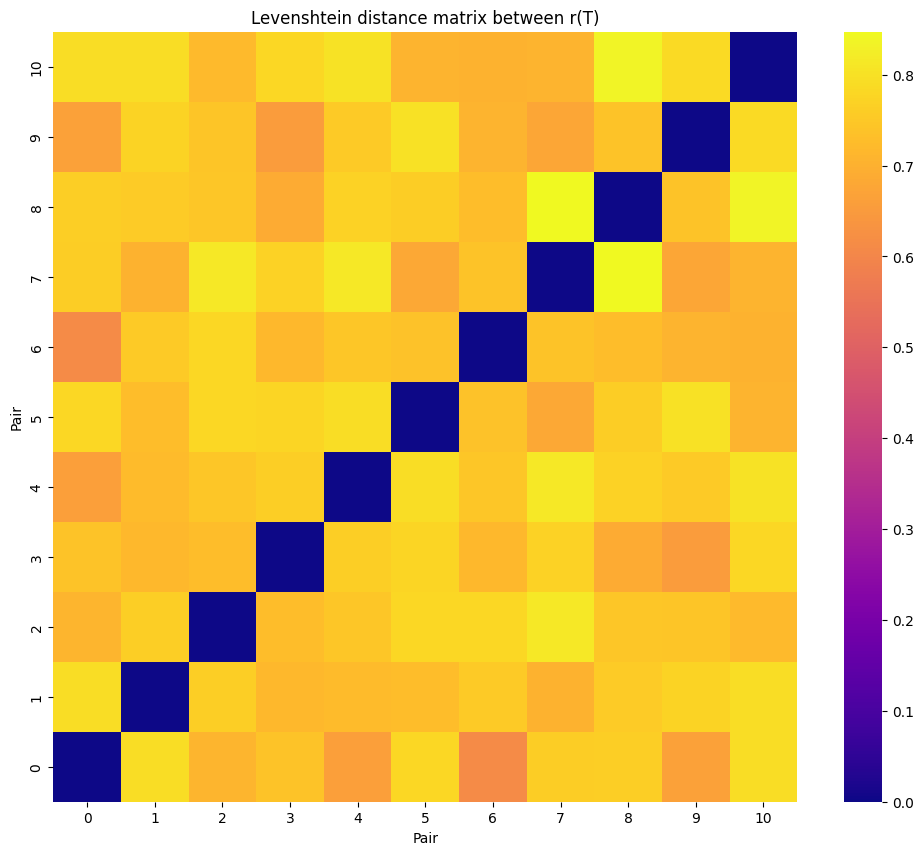

In [92]:


fig ,  ax = plt.subplots(figsize=(12,10))
sns.heatmap(matrix, cmap='plasma')

rect = Rectangle((54, 54),10, 10, fill=False, color='blue', lw=3)
ax.add_patch(rect)


ax.set_xlabel('Pair')
ax.set_ylabel('Pair')
'''
TICK SETINGS

x_ticks=[]
y_ticks=[]
for i in range(100):
    x_ticks.append(f'{int(random.uniform(0,10))}{int(random.uniform(0,10))}')
    #y_ticks.append(f'{reduction_set.couples[i][0]}{reduction_set.couples[i][1]}')
ax.set_xticks(np.arange(0.5,len(x_ticks)+0.5,1))
ax.set_xticklabels(x_ticks)
'''

ax.set_title('Levenshtein distance matrix between r(T)')
ax.invert_yaxis()
plt.show()

/tmp/ipykernel_3390/1586569097.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matrix, method='average')


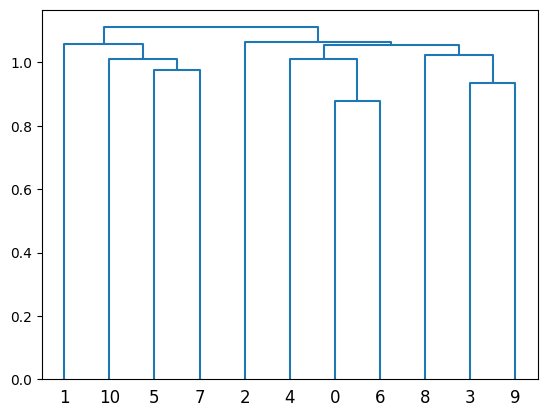

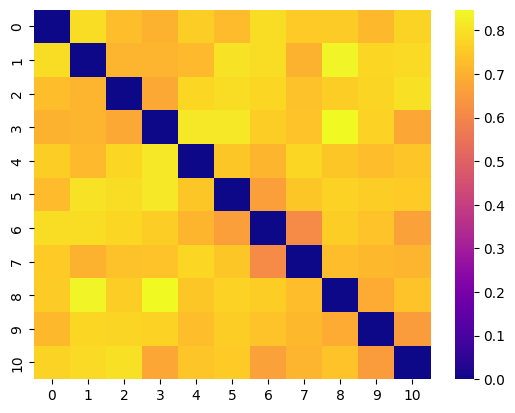

In [94]:

# Perform hierarchical/agglomerative clustering
Z = linkage(matrix, method='average')
dn = dendrogram(Z)
order = dn['leaves']
matrix_reordered = matrix[order,:][:,order]
fig, ax = plt.subplots()
sns.heatmap(matrix_reordered, cmap='plasma')
plt.show()